In [1]:
!nvidia-smi

Mon Sep 26 17:44:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:17:00.0 Off |                  Off |
| 30%   33C    P8    20W / 230W |     10MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:65:00.0  On |                  Off |
| 30%   

## 1) Installing libraries

In [1]:
# !pip install transformers
# !pip install datasets
# !pip install wandb
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset

## 2) Loading dataset (from HF)


In [3]:
# enter your personal read token

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
from datasets import load_dataset

aggression_dataset = load_dataset("IIIT-L/TRAC", use_auth_token=True)

print(aggression_dataset)

Using custom data configuration IIIT-L--TRAC-727fca9500a6c860
Reusing dataset csv (/home/diptesh/.cache/huggingface/datasets/IIIT-L___csv/IIIT-L--TRAC-727fca9500a6c860/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 9795
    })
    test: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 1225
    })
    validation: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 1224
    })
})


In [6]:
train_ds = aggression_dataset['train']
train_ds

Dataset({
    features: ['Sentence', 'Label'],
    num_rows: 9795
})

## 3) Converting to dataframe

In [7]:
aggression_dataset.set_format(type='pandas')
train_df = aggression_dataset['train'][:]
valid_df = aggression_dataset['validation'][:]

train_df.head()

,Sentence,Label
0,Mr. Prateek Nishant.....secure method?,1
1,Sane ppl couldn't do anything so far ....at le...,1
2,Moreover that idiot is fan of Terrorist Yakub ...,2
3,Shame shame & then these lowly so called educa...,2
4,I completely agree with your viewpoint.\nBut l...,0


In [8]:
test_df = aggression_dataset['test'][:]

In [9]:
train_df['Label'].value_counts()

0    4349
1    3274
2    2172
Name: Label, dtype: int64

In [10]:
# 9795
# NAG-CAG-OAG (0-1-2) = 0.45-0.33-0.22

Seeing Distribution

In [11]:
disb_df = train_df.copy(deep=True)

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


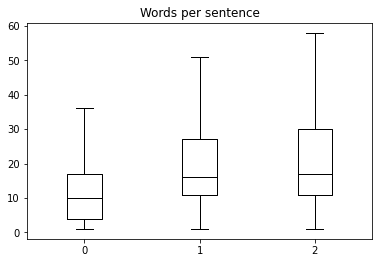

In [12]:
disb_df['Words per sentence'] = disb_df['Sentence'].str.split().apply(len)
disb_df.boxplot('Words per sentence', by='Label', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## 4) Tokenizing

In [13]:
from transformers import AutoTokenizer

In [14]:
model_ckpt = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [15]:
tokenizer.vocab_size

250002

In [16]:
train_texts = list(train_df['Sentence'])
train_labels = list(train_df['Label'])

In [17]:
valid_texts = list(valid_df['Sentence'])
valid_labels = list(valid_df['Label'])

## 5) Encoding train-valid

In [18]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)

In [19]:
import torch

class AggressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [20]:
train_dataset = AggressionDataset(train_encodings, train_labels)
valid_dataset = AggressionDataset(valid_encodings, valid_labels)

## 6) Setting classification model and evaluation metrics

In [21]:
import torch

In [22]:
# Use in case of CUDA memory error

# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [23]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def model_init():
    model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))
    return model

cuda


In [24]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

## 7) Fine-tuning, visualizing training, saving model to HF  

In [25]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: diptesh. Use `wandb login --relogin` to force relogin


True

In [26]:
%env WANDB_PROJECT = aggression_detection

env: WANDB_PROJECT=aggression_detection


In [27]:
from transformers import Trainer, TrainingArguments

In [28]:
# Defining hyperparameters
eval_batch_size = 16
logging_steps = len(train_texts) // eval_batch_size
model_name = f"{model_ckpt}-finetuned-TRAC-DS-new"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=6,
                                  learning_rate=1e-05,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=4,
                                  weight_decay=0.01,
                                  evaluation_strategy='steps',
                                  save_strategy='steps',
                                  max_steps=-1,
                                  warmup_ratio=0.0,
                                  seed=43,
                                  data_seed=4,
                                  metric_for_best_model="eval_f1",
                                  greater_is_better=True,
                                  load_best_model_at_end=True, 
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=logging_steps,
                                  log_level='info', 
                                  report_to="wandb", 
                                  run_name="xlmr-large-TRAC-DS-new",
                                  push_to_hub=True)

In [29]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [30]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    # device = torch.device('cuda')
    # inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.20, 0.33, 0.47]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [31]:
from transformers import EarlyStoppingCallback

In [32]:
# enter your personal write token here

from huggingface_hub import notebook_login
notebook_login()

In [33]:
trainer = CustomTrainer(model_init=model_init,
                        args=training_args,
                        compute_metrics = compute_metrics,
                        train_dataset = train_dataset,
                        eval_dataset = valid_dataset,
                        tokenizer = tokenizer 
                        # callbacks = [EarlyStoppingCallback(early_stopping_patience = 2, early_stopping_threshold=0.0001)]
)

trainer.train()

# post-training analysis, testing, other logged code
wandb.finish()

loading configuration file https://huggingface.co/xlm-roberta-large/resolve/main/config.json from cache at /home/diptesh/.cache/huggingface/transformers/4d7a1550c9ab8701667bc307a1213c040fcc06dc87a5e4994e72aecc0d7e0337.842c7737719967568f4691849854475018d6cf7ce21f52576bb6e0d10091bd3c
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-large",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_past": true,
  "pad_token_id": 1,

  0%|          | 0/14694 [00:00<?, ?it/s]

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 1.0895, 'learning_rate': 9.583503470804411e-06, 'epoch': 0.25}


  0%|          | 0/153 [00:00<?, ?it/s]

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-612
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-612/config.json


{'eval_loss': 1.0892544984817505, 'eval_accuracy': 0.4452614379084967, 'eval_precision': 0.322028435439549, 'eval_recall': 0.46544704437944606, 'eval_f1': 0.3553675850277946, 'eval_runtime': 21.1201, 'eval_samples_per_second': 57.954, 'eval_steps_per_second': 7.244, 'epoch': 0.25}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-612/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-612/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-612/special_tokens_map.json
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 1.0788, 'learning_rate': 9.16700694160882e-06, 'epoch': 0.5}


  0%|          | 0/153 [00:00<?, ?it/s]

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-1224
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-1224/config.json


{'eval_loss': 1.10508131980896, 'eval_accuracy': 0.44362745098039214, 'eval_precision': 0.14787581699346405, 'eval_recall': 0.3333333333333333, 'eval_f1': 0.20486700622524054, 'eval_runtime': 21.1519, 'eval_samples_per_second': 57.867, 'eval_steps_per_second': 7.233, 'epoch': 0.5}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-1224/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-1224/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-1224/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 1.0567, 'learning_rate': 8.75051041241323e-06, 'epoch': 0.75}


  0%|          | 0/153 [00:00<?, ?it/s]

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-1836
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-1836/config.json


{'eval_loss': 0.9506586790084839, 'eval_accuracy': 0.5637254901960784, 'eval_precision': 0.41764753413957495, 'eval_recall': 0.4947700675861261, 'eval_f1': 0.4279268614876804, 'eval_runtime': 21.0655, 'eval_samples_per_second': 58.105, 'eval_steps_per_second': 7.263, 'epoch': 0.75}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-1836/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-1836/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-1836/special_tokens_map.json
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 1.0052, 'learning_rate': 8.334013883217642e-06, 'epoch': 1.0}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-2448
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-2448/config.json


{'eval_loss': 0.9715923070907593, 'eval_accuracy': 0.4665032679738562, 'eval_precision': 0.4913408680275248, 'eval_recall': 0.5106333637842156, 'eval_f1': 0.432375983633918, 'eval_runtime': 20.8993, 'eval_samples_per_second': 58.567, 'eval_steps_per_second': 7.321, 'epoch': 1.0}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-2448/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-2448/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-2448/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.9862, 'learning_rate': 7.91751735402205e-06, 'epoch': 1.25}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-3060
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-3060/config.json


{'eval_loss': 0.9160383343696594, 'eval_accuracy': 0.5718954248366013, 'eval_precision': 0.5824426688397276, 'eval_recall': 0.5851096256042391, 'eval_f1': 0.5516684320484381, 'eval_runtime': 21.0619, 'eval_samples_per_second': 58.114, 'eval_steps_per_second': 7.264, 'epoch': 1.25}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-3060/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-3060/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-3060/special_tokens_map.json
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.9428, 'learning_rate': 7.50102082482646e-06, 'epoch': 1.5}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-3672
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-3672/config.json


{'eval_loss': 0.9251100420951843, 'eval_accuracy': 0.5645424836601307, 'eval_precision': 0.5838296992079516, 'eval_recall': 0.5902576147732955, 'eval_f1': 0.5385623928706875, 'eval_runtime': 21.3832, 'eval_samples_per_second': 57.241, 'eval_steps_per_second': 7.155, 'epoch': 1.5}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-3672/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-3672/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-3672/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.9381, 'learning_rate': 7.08452429563087e-06, 'epoch': 1.75}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-4284
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-4284/config.json


{'eval_loss': 0.921205997467041, 'eval_accuracy': 0.630718954248366, 'eval_precision': 0.6030620532813514, 'eval_recall': 0.6091365548141927, 'eval_f1': 0.6053121760970812, 'eval_runtime': 20.8159, 'eval_samples_per_second': 58.801, 'eval_steps_per_second': 7.35, 'epoch': 1.75}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-4284/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-4284/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-4284/special_tokens_map.json
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.9124, 'learning_rate': 6.66802776643528e-06, 'epoch': 2.0}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-4896
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-4896/config.json


{'eval_loss': 0.8896536231040955, 'eval_accuracy': 0.6053921568627451, 'eval_precision': 0.6078209095967579, 'eval_recall': 0.6169154794663142, 'eval_f1': 0.5894753809340497, 'eval_runtime': 20.7716, 'eval_samples_per_second': 58.927, 'eval_steps_per_second': 7.366, 'epoch': 2.0}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-4896/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-4896/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-4896/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.9558, 'learning_rate': 6.25153123723969e-06, 'epoch': 2.25}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-5508
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-5508/config.json


{'eval_loss': 0.8576462864875793, 'eval_accuracy': 0.6282679738562091, 'eval_precision': 0.633040593319744, 'eval_recall': 0.6076920637090022, 'eval_f1': 0.6094286052580263, 'eval_runtime': 21.0139, 'eval_samples_per_second': 58.247, 'eval_steps_per_second': 7.281, 'epoch': 2.25}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-5508/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-5508/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-5508/special_tokens_map.json
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.8814, 'learning_rate': 5.835034708044101e-06, 'epoch': 2.5}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-6120
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-6120/config.json


{'eval_loss': 0.9458037614822388, 'eval_accuracy': 0.6519607843137255, 'eval_precision': 0.6356560025322594, 'eval_recall': 0.6269682491501961, 'eval_f1': 0.6286061941752094, 'eval_runtime': 21.1354, 'eval_samples_per_second': 57.912, 'eval_steps_per_second': 7.239, 'epoch': 2.5}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-6120/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-6120/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-6120/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.8697, 'learning_rate': 5.41853817884851e-06, 'epoch': 2.75}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-6732
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-6732/config.json


{'eval_loss': 0.8927851915359497, 'eval_accuracy': 0.6380718954248366, 'eval_precision': 0.6303774928774929, 'eval_recall': 0.6259490186543218, 'eval_f1': 0.6227523061197962, 'eval_runtime': 21.4094, 'eval_samples_per_second': 57.171, 'eval_steps_per_second': 7.146, 'epoch': 2.75}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-6732/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-6732/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-6732/special_tokens_map.json
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.9142, 'learning_rate': 5.0020416496529204e-06, 'epoch': 3.0}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-7344
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-7344/config.json


{'eval_loss': 0.8542201519012451, 'eval_accuracy': 0.6225490196078431, 'eval_precision': 0.6226772112224369, 'eval_recall': 0.627228365151371, 'eval_f1': 0.612372719705114, 'eval_runtime': 20.7318, 'eval_samples_per_second': 59.04, 'eval_steps_per_second': 7.38, 'epoch': 3.0}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-7344/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-7344/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-7344/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.825, 'learning_rate': 4.58554512045733e-06, 'epoch': 3.25}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-7956
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-7956/config.json


{'eval_loss': 0.9638602137565613, 'eval_accuracy': 0.6576797385620915, 'eval_precision': 0.6490567847578829, 'eval_recall': 0.6089305489449154, 'eval_f1': 0.6092907598074381, 'eval_runtime': 20.6013, 'eval_samples_per_second': 59.414, 'eval_steps_per_second': 7.427, 'epoch': 3.25}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-7956/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-7956/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-7956/special_tokens_map.json
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.84, 'learning_rate': 4.16904859126174e-06, 'epoch': 3.5}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-8568
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-8568/config.json


{'eval_loss': 0.897972583770752, 'eval_accuracy': 0.6266339869281046, 'eval_precision': 0.6309103983678034, 'eval_recall': 0.6169112967740871, 'eval_f1': 0.6130076754878194, 'eval_runtime': 20.7589, 'eval_samples_per_second': 58.963, 'eval_steps_per_second': 7.37, 'epoch': 3.5}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-8568/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-8568/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-8568/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.8505, 'learning_rate': 3.7525520620661497e-06, 'epoch': 3.75}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-9180
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-9180/config.json


{'eval_loss': 0.9126660823822021, 'eval_accuracy': 0.6503267973856209, 'eval_precision': 0.6197383531090588, 'eval_recall': 0.6130037958980393, 'eval_f1': 0.6153692079928956, 'eval_runtime': 20.9306, 'eval_samples_per_second': 58.479, 'eval_steps_per_second': 7.31, 'epoch': 3.75}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-9180/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-9180/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-9180/special_tokens_map.json
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.8287, 'learning_rate': 3.3360555328705595e-06, 'epoch': 4.0}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-9792
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-9792/config.json


{'eval_loss': 0.9342697262763977, 'eval_accuracy': 0.6683006535947712, 'eval_precision': 0.6515394158235369, 'eval_recall': 0.6527425339054108, 'eval_f1': 0.6488471022300141, 'eval_runtime': 20.6411, 'eval_samples_per_second': 59.299, 'eval_steps_per_second': 7.412, 'epoch': 4.0}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-9792/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-9792/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-9792/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.7772, 'learning_rate': 2.9195590036749692e-06, 'epoch': 4.25}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-10404
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-10404/config.json


{'eval_loss': 1.043388843536377, 'eval_accuracy': 0.6650326797385621, 'eval_precision': 0.6461405735648761, 'eval_recall': 0.6453858569998668, 'eval_f1': 0.6437368450934992, 'eval_runtime': 20.9757, 'eval_samples_per_second': 58.353, 'eval_steps_per_second': 7.294, 'epoch': 4.25}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-10404/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-10404/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-10404/special_tokens_map.json
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.8217, 'learning_rate': 2.50306247447938e-06, 'epoch': 4.5}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-11016
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-11016/config.json


{'eval_loss': 0.976023256778717, 'eval_accuracy': 0.6723856209150327, 'eval_precision': 0.6573737562280386, 'eval_recall': 0.6549579150530745, 'eval_f1': 0.6532935864445638, 'eval_runtime': 20.6376, 'eval_samples_per_second': 59.309, 'eval_steps_per_second': 7.414, 'epoch': 4.5}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-11016/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-11016/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-11016/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.7543, 'learning_rate': 2.0865659452837896e-06, 'epoch': 4.75}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-11628
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-11628/config.json


{'eval_loss': 1.0789703130722046, 'eval_accuracy': 0.6454248366013072, 'eval_precision': 0.6521677884034499, 'eval_recall': 0.6342400968636474, 'eval_f1': 0.6327336079727132, 'eval_runtime': 21.0424, 'eval_samples_per_second': 58.168, 'eval_steps_per_second': 7.271, 'epoch': 4.75}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-11628/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-11628/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-11628/special_tokens_map.json
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.7868, 'learning_rate': 1.6700694160881993e-06, 'epoch': 5.0}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-12240
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-12240/config.json


{'eval_loss': 1.145740270614624, 'eval_accuracy': 0.670751633986928, 'eval_precision': 0.6518902182952303, 'eval_recall': 0.6445476686534345, 'eval_f1': 0.6462644976620348, 'eval_runtime': 20.8705, 'eval_samples_per_second': 58.647, 'eval_steps_per_second': 7.331, 'epoch': 5.0}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-12240/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-12240/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-12240/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.8093, 'learning_rate': 1.253572886892609e-06, 'epoch': 5.25}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-12852
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-12852/config.json


{'eval_loss': 1.1713558435440063, 'eval_accuracy': 0.6715686274509803, 'eval_precision': 0.6517399222003611, 'eval_recall': 0.6525421895694118, 'eval_f1': 0.6508643537539204, 'eval_runtime': 20.756, 'eval_samples_per_second': 58.971, 'eval_steps_per_second': 7.371, 'epoch': 5.25}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-12852/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-12852/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-12852/special_tokens_map.json
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.8032, 'learning_rate': 8.370763576970193e-07, 'epoch': 5.5}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-13464
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-13464/config.json


{'eval_loss': 1.188241958618164, 'eval_accuracy': 0.6691176470588235, 'eval_precision': 0.6479954165606227, 'eval_recall': 0.6542103940100492, 'eval_f1': 0.6489145128600667, 'eval_runtime': 20.986, 'eval_samples_per_second': 58.325, 'eval_steps_per_second': 7.291, 'epoch': 5.5}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-13464/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-13464/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-13464/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.7511, 'learning_rate': 4.205798285014292e-07, 'epoch': 5.75}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-14076
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-14076/config.json


{'eval_loss': 1.2112598419189453, 'eval_accuracy': 0.6650326797385621, 'eval_precision': 0.641294844941032, 'eval_recall': 0.6458458483016326, 'eval_f1': 0.6428528641753999, 'eval_runtime': 20.7146, 'eval_samples_per_second': 59.089, 'eval_steps_per_second': 7.386, 'epoch': 5.75}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-14076/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-14076/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-14076/special_tokens_map.json
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1224
  Batch size = 8


{'loss': 0.7698, 'learning_rate': 4.083299305839119e-09, 'epoch': 6.0}


  0%|          | 0/153 [00:00<?, ?it/s]

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-14688
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-14688/config.json


{'eval_loss': 1.2229201793670654, 'eval_accuracy': 0.6723856209150327, 'eval_precision': 0.6503050181168842, 'eval_recall': 0.6556355277480465, 'eval_f1': 0.6512991019294255, 'eval_runtime': 20.8282, 'eval_samples_per_second': 58.767, 'eval_steps_per_second': 7.346, 'epoch': 6.0}


Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-14688/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-14688/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-14688/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from xlm-roberta-large-finetuned-TRAC-DS-new/checkpoint-11016 (score: 0.6532935864445638).


{'train_runtime': 9648.2405, 'train_samples_per_second': 6.091, 'train_steps_per_second': 1.523, 'train_loss': 0.8853816887432496, 'epoch': 6.0}


eval/accuracy,▁▁▅▂▅▅▇▆▇▇▇▆█▇▇███▇█████
eval/f1,▃▁▄▅▆▆▇▇▇██▇▇▇▇█████████
eval/loss,▅▆▃▃▂▂▂▂▁▃▂▁▃▂▂▃▅▃▅▇▇▇██
eval/precision,▃▁▅▆▇▇▇▇██████▇█████████
eval/recall,▄▁▅▅▆▇▇▇▇▇▇▇▇▇▇█████████
eval/runtime,▅▆▅▄▅█▃▂▅▆█▂▁▂▄▁▄▁▅▃▂▄▂▃
eval/samples_per_second,▃▃▄▅▄▁▆▆▄▃▁▇█▇▅█▅█▄▆▇▅▇▆
eval/steps_per_second,▃▃▄▅▄▁▆▆▄▃▁▇█▇▅█▅█▄▆▇▅▇▆
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,██▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁


In [34]:
trainer.push_to_hub()

Saving model checkpoint to xlm-roberta-large-finetuned-TRAC-DS-new
Configuration saved in xlm-roberta-large-finetuned-TRAC-DS-new/config.json
Model weights saved in xlm-roberta-large-finetuned-TRAC-DS-new/pytorch_model.bin
tokenizer config file saved in xlm-roberta-large-finetuned-TRAC-DS-new/tokenizer_config.json
Special tokens file saved in xlm-roberta-large-finetuned-TRAC-DS-new/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/2.09G [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/dipteshkanojia/xlm-roberta-large-finetuned-TRAC-DS-new
   d6a05f5..1017f10  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.6723856209150327}, {'name': 'Precision', 'type': 'precision', 'value': 0.6503050181168842}, {'name': 'Recall', 'type': 'recall', 'value': 0.6556355277480465}, {'name': 'F1', 'type': 'f1', 'value': 0.6512991019294255}]}
To https://huggingface.co/dipteshkanojia/xlm-roberta-large-finetuned-TRAC-DS-new
   1017f10..9d8cb05  main -> main



'https://huggingface.co/dipteshkanojia/xlm-roberta-large-finetuned-TRAC-DS-new/commit/1017f10c22cba4f78b1f05e9d84599444b87824c'

## 8) Predictions and Results

In [35]:
test_texts = list(test_df['Sentence'])
test_labels = list(test_df['Label'])

In [36]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [37]:
test_dataset = AggressionDataset(test_encodings, test_labels)

In [38]:
preds_output_test = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1225
  Batch size = 8
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/154 [00:00<?, ?it/s]

In [39]:
preds_output_test.metrics

{'test_loss': 0.8918405175209045,
 'test_accuracy': 0.7004081632653061,
 'test_precision': 0.6817381119374075,
 'test_recall': 0.680220603676625,
 'test_f1': 0.6800458313039165,
 'test_runtime': 17.7964,
 'test_samples_per_second': 68.834,
 'test_steps_per_second': 8.653}

In [40]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

In [41]:
y_valid_test = np.array(test_dataset.labels)

In [42]:
map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}

In [43]:
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

              precision    recall  f1-score   support

         NAG       0.85      0.78      0.81       544
         CAG       0.60      0.66      0.62       410
         OAG       0.60      0.60      0.60       271

    accuracy                           0.70      1225
   macro avg       0.68      0.68      0.68      1225
weighted avg       0.71      0.70      0.70      1225



In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

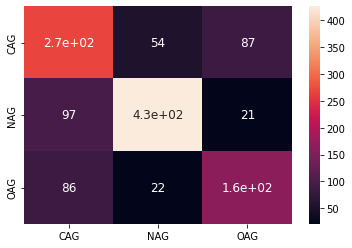

In [45]:
cm_labels = np.unique(y_valid_trying)
cm_array = confusion_matrix(y_valid_trying, y_preds_trying)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12}) 